In [44]:
import numpy as np
from scipy.stats import poisson, chi2
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from sklearn.ensemble import GradientBoostingRegressor
from skgarden import RandomForestQuantileRegressor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tqdm.auto import tqdm
from sklearn.model_selection import GridSearchCV

import os 
import statsmodels.api as sm
import sys, traceback

class Suppressor(object):

    def __enter__(self):
        self.stdout = sys.stdout
        sys.stdout = self

    def __exit__(self, type, value, traceback):
        sys.stdout = self.stdout
        if type is not None:
            pass

    def write(self, x): pass

## Tables 2 (section 4) and Table 3 (Supp. Mat)

In [24]:
directory = 'sims/table2/'
files = [x for x in os.listdir(directory) if 'csv' in x and 'truth' not in x]
for line in files:
    print(line)
final_df = None

for flnm in files:
    temp_df = pd.read_csv(directory + flnm, index_col=0)
    temp_df['classifier'] = temp_df['classifier'].apply(lambda x: x.replace('\n ', ''))
    temp_df['classifier_cde'] = temp_df['classifier_cde'].apply(lambda x: x.replace('\n ', ''))
    
    if 'in_true_interval' in temp_df.columns:
        temp_df['in_true_interval'] = temp_df['in_true_interval'].values
    if final_df is None:
        final_df = temp_df.copy()
    else:
        final_df = final_df.append(temp_df.copy())

classifier_reps_cov_pow_toy_100B_2500Bprime_poisson_100rep_alpha0-1_sampleobs10_t0val10-0_lgb_2020-02-01.csv
classifier_reps_cov_pow_toy_500B_2500Bprime_poisson_100rep_alpha0-1_sampleobs10_t0val10-0_lgb_2020-02-01.csv
classifier_reps_cov_pow_toy_500B_5000Bprime_gmm_100rep_alpha0-1_sampleobs10_t0val5-0_xgb_d3_n100_2020-02-01.csv
classifier_reps_cov_pow_toy_1000B_5000Bprime_gmm_100rep_alpha0-1_sampleobs10_t0val5-0_xgb_d3_n100_2020-02-01.csv
classifier_reps_cov_pow_toy_100B_5000Bprime_gmm_100rep_alpha0-1_sampleobs10_t0val5-0_xgb_d3_n100_2020-02-01.csv
classifier_reps_cov_pow_toy_1000B_2500Bprime_poisson_100rep_alpha0-1_sampleobs10_t0val10-0_lgb_2020-02-01.csv


In [25]:
print(final_df['b_prime'].unique())
print(final_df['b'].unique())
print(final_df['classifier'].unique())
print(final_df['classifier_cde'].unique())
print(final_df['run'].unique())
print(final_df['sample_size_obs'].unique())
print(final_df['rep'].unique())

[2500 5000]
[ 100  500 1000]
['MLP' 'NN' 'QDA']
['lgb' 'xgb_d3_n100']
['poisson' 'gmm']
[10]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [26]:
def print_table_to_latex(df, hue='classifier'):
    final_row = '\%s \hline' % ('\\')
    hue_vals = df[hue].unique()
    b_vals = df['b'].unique()
    out = []
    
    for b_val in b_vals:
        for jj, hue_val in enumerate(hue_vals):
            temp_df = df[(df[hue] == hue_val) & (df['b'] == b_val)]
            temp_line = '%s & %s & %.2f $\pm$ %.2f & %.2f & %.1f $\pm$ %.1f' % (
            '\multirow{3}{*}{%s}' % ('{:,}'.format(b_val)) if jj == 0 else '', 
                hue_val, 
                temp_df['cross_entropy_loss average'].values[0],
                temp_df['cross_entropy_loss std'].values[0],
                temp_df['out_confint notrue'].values[0],
                temp_df['size_CI average'].values[0],
                temp_df['size_CI std'].values[0]
            )
            if jj == 2:
                out.append(temp_line + final_row)
            else:
                out.append(temp_line + '\%s' % ('\\'))
            
    for line in out:
        print(line)

        
def print_coverage_table_to_latex(df, hue='classifier'):
    final_row = '\%s \hline' % ('\\')
    hue_vals = df[hue].unique()
    b_vals = df['b'].unique()
    out = []
    
    for b_val in b_vals:
        for jj, hue_val in enumerate(hue_vals):
            temp_df = df[(df[hue] == hue_val) & (df['b'] == b_val)]
            temp_line = '%s & %s & %.2f' % (
            '\multirow{3}{*}{%s}' % ('{:,}'.format(b_val)) if jj == 0 else '', 
                hue_val, 
                temp_df['in_confint average'].values[0])
            if jj == 2:
                out.append(temp_line + final_row)
            else:
                out.append(temp_line + '\%s' % ('\\'))
            
    for line in out:
        print(line)

/Users/NicDalmasso/python3_envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


      b classifier  cross_entropy_loss average  cross_entropy_loss std  \
0   100        MLP                        0.87                    0.27   
1   100         NN                        0.76                    0.15   
2   100        QDA                        0.66                    0.02   
3   500        MLP                        0.69                    0.00   
4   500         NN                        0.67                    0.01   
5   500        QDA                        0.64                    0.00   
6  1000        MLP                        0.69                    0.01   
7  1000         NN                        0.66                    0.01   
8  1000        QDA                        0.64                    0.00   

   out_confint average  size_CI average  size_CI std  out_confint notrue  
0                 0.24            75.88        19.31                0.24  
1                 0.28            71.59        19.68                0.29  
2                 0.40            

/Users/NicDalmasso/python3_envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/NicDalmasso/python3_envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


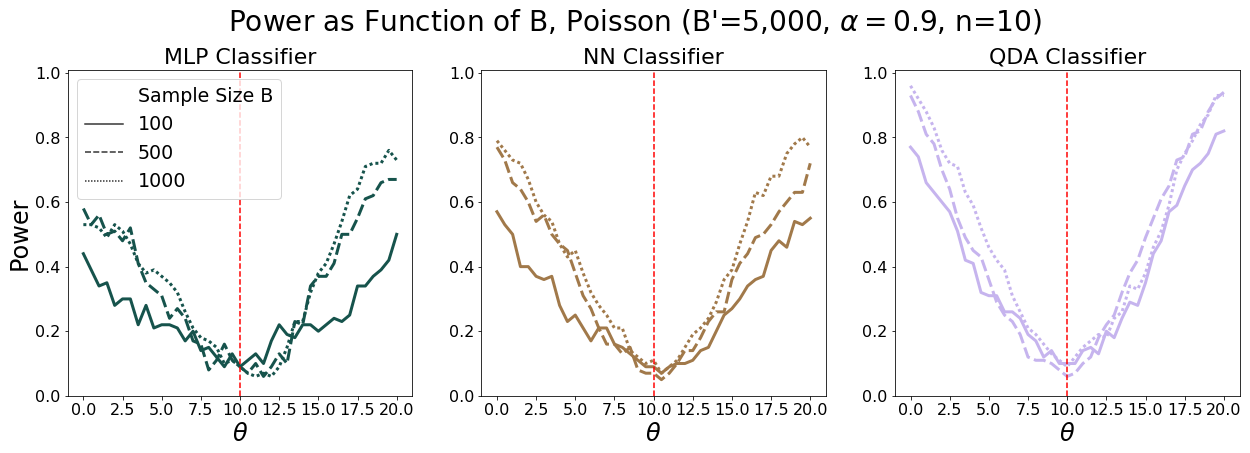



      b classifier  cross_entropy_loss average  cross_entropy_loss std  \
0   100        MLP                        0.39                    0.03   
1   100         NN                        0.81                    0.31   
2   100        QDA                        0.64                    0.02   
3   500        MLP                        0.35                    0.01   
4   500         NN                        0.45                    0.05   
5   500        QDA                        0.62                    0.00   
6  1000        MLP                        0.35                    0.00   
7  1000         NN                        0.41                    0.02   
8  1000        QDA                        0.62                    0.00   

   out_confint average  size_CI average  size_CI std  out_confint notrue  
0                 0.86            14.10         4.69                0.88  
1                 0.42            58.39        23.27                0.42  
2                 0.15          

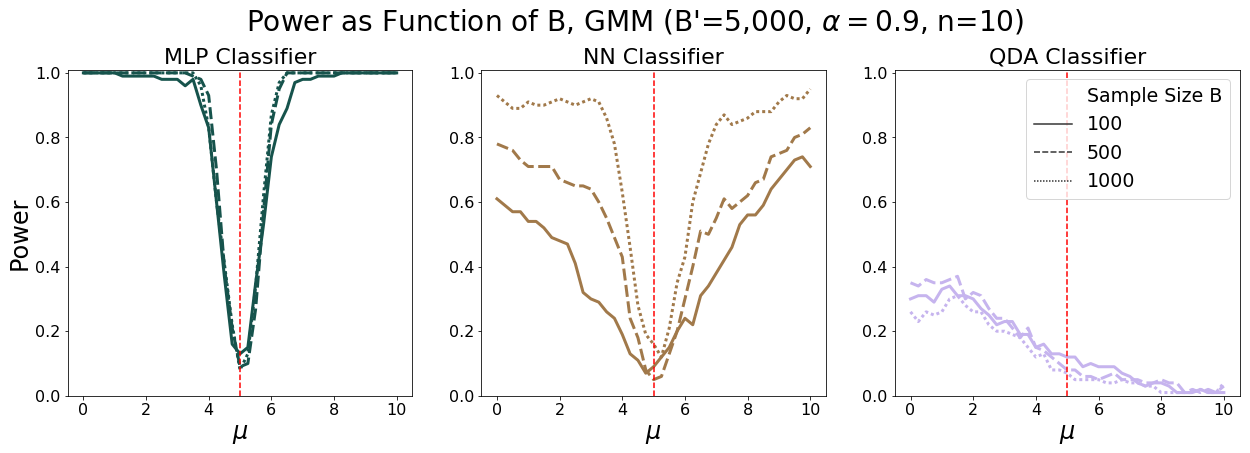

In [28]:
sample_size_val = 10
color_palette = sns.color_palette("cubehelix", 3)

for run in ['poisson', 'gmm']:
    b_prime_val = 2500 if run == 'poisson' else 5000
    class_cde = 'lgb' if run=='poisson' else 'xgb_d3_n100'
    plot_df = final_df[(final_df['run'] == run) &
                       (final_df['classifier_cde'] == class_cde) &
                       (final_df['sample_size_obs'] == sample_size_val) &
                       (final_df['b_prime'] == b_prime_val)]
    
    true_t0 = plot_df[plot_df['on_true_t0'] == 1]['theta_0_current'].values[0]

    size_CI_df = plot_df[['b', 'classifier', 'cross_entropy_loss', 'size_CI', 'out_confint', 'on_true_t0']]
    out_confint_outint = size_CI_df[size_CI_df['on_true_t0']==0].groupby(['b', 'classifier']).agg({
                                                       'out_confint': [np.average]}).round(2)['out_confint']
    size_CI_df['size_CI'] = size_CI_df['size_CI'].values * 100
    size_CI_df = size_CI_df.groupby(['b', 'classifier']).agg({'size_CI': [np.average, np.std],
                                                      'cross_entropy_loss': [np.average, np.std],
                                                       'out_confint': [np.average]}).round(2).reset_index()
    size_CI_df.columns = [' '.join(col).strip() for col in size_CI_df.columns.values]
    size_CI_df['out_confint notrue'] = out_confint_outint.values
    print(size_CI_df)
    print_table_to_latex(size_CI_df)
    print('\n')
    
    
    
    coverage_df = plot_df[plot_df['on_true_t0'] == 1.0][
        ['b', 'classifier', 'cross_entropy_loss', 'in_confint']]
    coverage_df = coverage_df.groupby(['b', 'classifier']).agg({'in_confint': [np.average, np.std],
                                                      'cross_entropy_loss': [np.average, np.std]}).round(2).reset_index()
    coverage_df.columns = [' '.join(col).strip() for col in coverage_df.columns.values]
    print_coverage_table_to_latex(coverage_df)
    
    
    truth_flnm = [x for x in os.listdir(directory) if 'truth' in x and run in x][0]
    truth_df = pd.read_csv(directory + truth_flnm).set_index('Unnamed: 0')
    power_vec = 1.0 - truth_df[truth_df['on_true_t0']==0].groupby(['classifier']).agg(
                        {'in_true_interval': np.average}).reset_index()['in_true_interval'].values
    summary_truth_df = truth_df.groupby(['classifier']).agg({'size_true_int': [np.average, np.std],
                                            'true_entropy': [np.average, np.std]})
    summary_truth_df['power'] = power_vec
    print(summary_truth_df.round(4))
    
    
    classifier_column_name = 'OR Classifier'
    b_col_name = "Sample Size B"
    plot_df[b_col_name] = np.array(plot_df['b'].values)
    plot_df[classifier_column_name] = plot_df['classifier']
    plot_df = plot_df[[classifier_column_name, 'theta_0_current', 'out_confint', b_col_name]].groupby(
        [classifier_column_name, 'theta_0_current', b_col_name]).mean().reset_index()

    
    fig = plt.figure(figsize=(21,6))
    for jj, clf_odds in enumerate(plot_df[classifier_column_name].unique()):
        
        temp_df = plot_df[plot_df[classifier_column_name] == clf_odds]
        
        ax = fig.add_subplot(1, 3, jj + 1)
        sns.lineplot(x='theta_0_current', y='out_confint', color=color_palette[jj],
                     style=b_col_name, linewidth=3, data=temp_df)
        plt.xlabel(r'$\theta$' if run == 'poisson' else r'$\mu$', fontsize=24)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        if jj == 0:
            plt.ylabel('Power', fontsize=24)
        else:
            plt.ylabel('')
        plt.ylim([0, 1.01])
        plt.title("%s Classifier" % (clf_odds), fontsize=22)
        plt.axvline(x=true_t0, color='red', linestyle='--')
        if jj == 0 and run=='poisson':
            plt.legend(loc='upper left', fontsize=19)
        elif jj == 2 and run =='gmm':
            plt.legend(loc='upper right', fontsize=19)
        else:
            ax.get_legend().remove()
    title_run = 'Poisson' if run == 'poisson' else 'GMM'
    plt.suptitle("Power as Function of B, %s (B'=%s, %s, n=%s)" % (
        title_run, '5,000', r'$\alpha=0.9$', sample_size_val), y=1.025, fontsize=28)
    image_name = 'power_plot_function_bprime%s_n%s_%s.pdf' % (5000, sample_size_val, run)
    plt.savefig('images/toy_examples/' + image_name,
                bbox_inches='tight')
    plt.show()
    
    print('\n')

## Figure 6 (Supp. Mat.)

In [37]:
directory = 'sims/figure6/'
files = [x for x in os.listdir(directory) if 'csv' in x]
final_df_cov = None

for flnm in files:
    temp_df = pd.read_csv(directory + flnm, index_col=0)
    temp_df['classifier'] = temp_df['classifier'].apply(lambda x: x.replace('\n', ''))
    temp_df['classifier_cde'] = temp_df['classifier_cde'].apply(lambda x: x.replace('\n', ''))
    
    temp_df['B'] = temp_df['b_prime']
    temp_df['B_PRIME'] = temp_df['b']
    if final_df_cov is None:
        final_df_cov = temp_df.copy()
    else:
        final_df_cov = final_df_cov.append(temp_df.copy())
        
final_df_cov['b'] = final_df_cov['B']
final_df_cov['b_prime'] = final_df_cov['B_PRIME']

In [38]:
print(final_df_cov['b_prime'].unique())
print(final_df_cov['b'].unique())
print(final_df_cov['classifier'].unique())
print(final_df_cov['classifier_cde'].unique())
print(final_df_cov['run'].unique())
print(final_df_cov['sample_size_obs'].unique())
print(final_df_cov['rep'].unique())
print(final_df_cov.columns)

[ 100 1000  500]
[1000]
['MLP' 'QDA']
['XGBoost  (d3, n500)']
['gmm' 'poisson']
[10]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Index(['b_prime', 'b', 'classifier', 'classifier_cde', 'run', 'rep',
       'sample_size_obs', 'pinball_loss', 'theta_0_current', 'estimated_tau',
       'estimated_cutoff', 'in_confint', 'out_confint', 'B', 'B_PRIME'],
      dtype='object')


                   pinball_loss       in_confint                
                        average   std    average   std amin amax
B_PRIME classifier                                              
100     QDA                0.63  0.18       0.85  0.36    0    1
500     QDA                0.70  0.18       0.88  0.32    0    1
1000    QDA                0.68  0.14       0.89  0.31    0    1


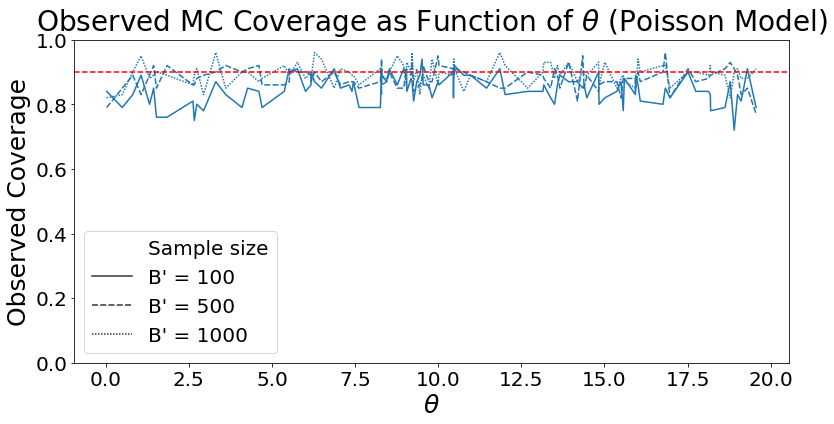

                   pinball_loss       in_confint                
                        average   std    average   std amin amax
B_PRIME classifier                                              
100     MLP                2.54  0.19       0.86  0.35    0    1
500     MLP                2.55  0.18       0.88  0.33    0    1
1000    MLP                2.52  0.18       0.90  0.31    0    1


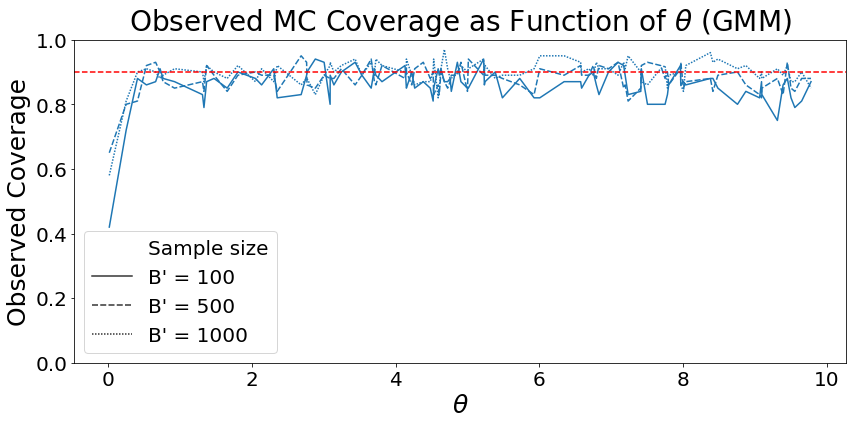

In [40]:
## Coverage of Plot -- Varying as a function of B

b_val = 1000

for run in ['poisson', 'gmm']:
    for class_cde in ['XGBoost  (d3, n500)']:
        plt.figure(figsize=(12,6))
        plot_df = final_df_cov[(final_df_cov['run'] == run) & 
                           (final_df_cov['classifier_cde'] == 'XGBoost  (d3, n500)') &
                           (final_df_cov['sample_size_obs'] == 10)]
        
        plot_df = plot_df[plot_df['B'] == b_val]
        
        plot_df['b_prime'] = plot_df['b_prime'].apply(lambda x: "B' = %s" % str(x))
        
        coverage_df = plot_df[['B_PRIME', 'classifier', 'pinball_loss', 'in_confint']]
        print(coverage_df.groupby(['B_PRIME', 'classifier']).agg({'in_confint': [np.average, np.std, np.min, np.max],
                                                      'pinball_loss': [np.average, np.std]}).round(2))

        class_combo_name = 'Odds Class./Critical Value Class.'
        b_col_name = "Sample size"
        plot_df[class_combo_name] = plot_df[['classifier', 'classifier_cde']].apply(lambda x: x[0] + '/' + x[1], axis = 1)
        plot_df[b_col_name] = plot_df['b_prime']
        plot_df = plot_df[[class_combo_name, 'theta_0_current', 'in_confint', b_col_name]].groupby(
            [class_combo_name, 'theta_0_current', b_col_name]).mean().reset_index()

        sns.lineplot(x='theta_0_current', y='in_confint', style=b_col_name, 
                     style_order=sorted(plot_df[b_col_name].unique(), key=lambda x: int(x.split('=')[1])),
                     data=plot_df)
        plt.xlabel(r'$\theta$', fontsize=25)
        plt.ylabel('Observed Coverage', fontsize=25)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        plt.title("Observed MC Coverage as Function of %s (%s)" % (
            r'$\theta$','Poisson Model' if run == 'poisson' else 'GMM'), 
                     fontsize=28, y=1.01)
        plt.axhline(y=0.9, color='red', linestyle='--')
        plt.legend(loc='lower left', fontsize=20)
        plt.ylim([0,1])
        plt.tight_layout()
        image_name = 'coverage_MC_plot_function_bbprime_b%s_classcde%s_n100_%s.pdf' % (
            run, b_val, class_cde.replace(' ', '_'))
        plt.savefig('images/toy_examples/' + image_name)
        plt.show()

## Figures 3 (Section 4) and 5 (Supp. Mat.)

In [45]:
directory = 'sims/figures3-5/'
files = [x for x in os.listdir(directory) if 'csv' in x]
final_df_cov = None

for flnm in files:
    temp_df = pd.read_csv(directory + flnm, index_col=0)
    temp_df['classifier'] = temp_df['classifier'].apply(lambda x: x.replace('\n', ''))
    temp_df['classifier_cde'] = temp_df['classifier_cde'].apply(lambda x: x.replace('\n', ''))
    
    temp_df['B'] = temp_df['b_prime']
    temp_df['B_PRIME'] = temp_df['b']
    if final_df_cov is None:
        final_df_cov = temp_df.copy()
    else:
        final_df_cov = final_df_cov.append(temp_df.copy())
        
final_df_cov['b'] = final_df_cov['B']
final_df_cov['b_prime'] = final_df_cov['B_PRIME']

In [46]:
print(final_df_cov['b_prime'].unique())
print(final_df_cov['b'].unique())
print(final_df_cov['classifier'].unique())
print(final_df_cov['classifier_cde'].unique())
print(final_df_cov['run'].unique())
print(final_df_cov['sample_size_obs'].unique())
print(final_df_cov['rep'].unique())
print(final_df_cov.columns)

[ 500 1000  100]
[1000]
['QDA' 'MLP']
['XGBoost  (d3, n500)']
['poisson' 'gmm']
[10]
[0]
Index(['b_prime', 'b', 'classifier', 'classifier_cde', 'run', 'rep',
       'sample_size_obs', 'pinball_loss', 'theta_0_current', 'estimated_tau',
       'estimated_cutoff', 'in_confint', 'out_confint', 'B', 'B_PRIME'],
      dtype='object')


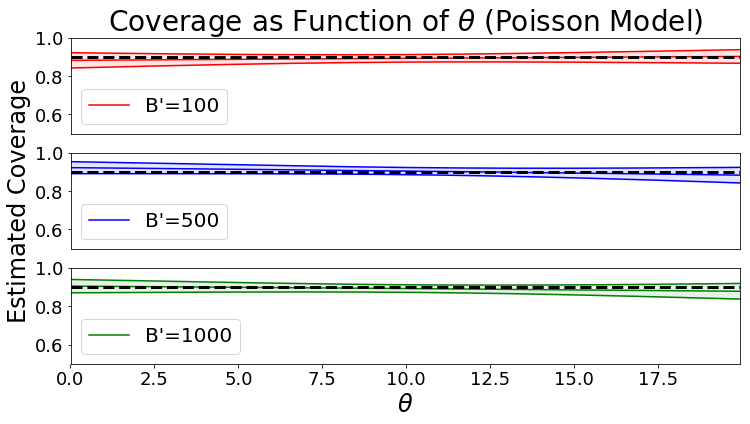

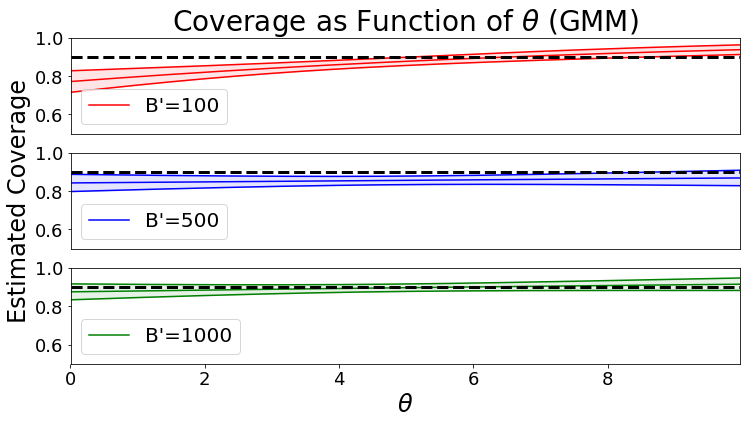

In [48]:
b_val = 1000
color_vec = ['red', 'blue', 'green']
n_grid = len(final_df_cov['theta_0_current'].unique())


for run in ['poisson', 'gmm']:
    plot_df = final_df_cov[(final_df_cov['run'] == run) & 
                       (final_df_cov['classifier_cde'] == 'XGBoost  (d3, n500)') &
                       (final_df_cov['sample_size_obs'] == 10)]
    plot_df = plot_df[plot_df['b'] == b_val]

    class_combo_name = 'Odds Class./Critical Value Class.'
    b_col_name = "Number of Available B'"
    plot_df[class_combo_name] = plot_df['classifier']
    plot_df[b_col_name] = plot_df['b_prime']
    plot_df = plot_df[[class_combo_name, 'theta_0_current', 'in_confint', b_col_name]].groupby(
        [class_combo_name, 'theta_0_current', b_col_name]).mean().reset_index()

    b_vec = np.sort(plot_df[b_col_name].unique())
    fig = plt.figure(figsize=(12,6))
    for ii, b_prime_val in enumerate(b_vec):
        temp_df = plot_df[plot_df[b_col_name] == b_prime_val]
        x = temp_df['theta_0_current'].values 
        y = temp_df['in_confint'].values    
        # estimate the model
        X = sm.add_constant(x)

        with Suppressor():
            model = sm.Logit(y, X).fit(full_output=False)
        proba = model.predict(X) 

        # estimate confidence interval for predicted probabilities
        cov = model.cov_params()
        gradient = (proba * (1 - proba) * X.T).T # matrix of gradients for each observation
        std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])
        c = 1 # multiplier for confidence interval
        upper = np.maximum(0, np.minimum(1, proba + std_errors * c))
        lower = np.maximum(0, np.minimum(1, proba - std_errors * c))

        x_plot = x[:n_grid]
        proba_plot = proba[:n_grid]
        lower_plot = lower[:n_grid]
        upper_plot = np.clip(upper[:n_grid], a_min=0, a_max=1.0)

        ax = fig.add_subplot(3, 1, ii + 1)
        sns.lineplot(x=x_plot, y=proba_plot, color=color_vec[ii], label="B'=%s" % b_prime_val)
        sns.lineplot(x=x_plot, y=lower_plot, color=color_vec[ii])
        sns.lineplot(x=x_plot, y=upper_plot, color=color_vec[ii])
        plt.fill_between(x=x_plot, y1=lower_plot, y2=upper_plot, alpha=0.1, color=color_vec[ii])

        plt.axhline(y=0.9, color='black', linestyle='--', linewidth=3)
        plt.legend(loc='lower left', fontsize=20)
        plt.ylim([0.5,1])
        plt.xlim([plot_df['theta_0_current'].min(), plot_df['theta_0_current'].max()])
        if ii == 0:
            plt.title("Coverage as Function of %s (%s)" % (
                r'$\theta$','Poisson Model' if run == 'poisson' else 'GMM'), 
                         fontsize=28, y=1.01)
        if ii == 2:
            plt.xticks(fontsize=18)
            plt.xlabel(r'$\theta$', fontsize=24) 
        else:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
        plt.yticks(fontsize=18)
        if ii == 1:
            plt.ylabel('Estimated Coverage', fontsize=24)
    image_name = 'coverage_plot_function_bprime_b%s_n100_%s.pdf' % (
        b_val, run)
    plt.savefig('images/toy_examples/' + image_name,
               bbox_inches='tight')
    plt.show()